In [1]:
# importing the necessary packages
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report

# reading in the csv file
data = pd.read_csv('final_data.csv', index_col=0, header=0)
data.columns

Index(['year', 'agent', 'pay_method', 'state', 'status', 'pay_method_ACH',
       'pay_method_credit card', 'pay_method_paper check', 'region_central',
       'region_east', 'region_south', 'region_west', 'status_Active',
       'status_Decline', 'status_Returned', 'status_Returned_90', 'income',
       'Y'],
      dtype='object')

In [2]:
# Dropping rows that will not be used in the random forest
data = data.drop(['agent', 'pay_method', 'state', 'status'], axis = 1)

data.columns

Index(['year', 'pay_method_ACH', 'pay_method_credit card',
       'pay_method_paper check', 'region_central', 'region_east',
       'region_south', 'region_west', 'status_Active', 'status_Decline',
       'status_Returned', 'status_Returned_90', 'income', 'Y'],
      dtype='object')

In [3]:
# Splitting the data in the X and y variables
X = data.iloc[:,:-1]
Y = data['Y']

# Splitting the data in training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=2019)

In [4]:
# Converting the data set into a matrix
data_matrix = xgb.DMatrix(data=X,label=Y)

/opt/tljh/user/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/tljh/user/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [5]:
# Getting the counts for the majority and minority class 
# in order to set the scale_pos_weight parameter to the
# majority class divided by the minority class
y_train.value_counts()

0    26541
1    14382
Name: Y, dtype: int64

In [6]:
# Starting the XGBoost
xg_reg = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

# Fitting the xg_reg variable
xg_reg = xg_reg.fit(X_train, y_train)

# Creating the y_pred variable
y_pred = xg_reg.predict(X_test)

# Creating the confusion matrix
cnf_mat = metrics.confusion_matrix(y_test, y_pred)
cnf_mat

array([[7951,  952],
       [2313, 2426]])

In [7]:
# Printing metrics for the model
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average='weighted'))
print("AUC:", metrics.roc_auc_score(y_test,y_pred))
print("MCC:",metrics.matthews_corrcoef(y_test, y_pred))

Accuracy: 0.7606655915554904
Precision: 0.7181764357608053
Recall: 0.5119223464866005
F1 Score: 0.7490979223947799
AUC: 0.7024960491278336
MCC: 0.44675553988439204


In [8]:
# Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      8903
           1       0.72      0.51      0.60      4739

    accuracy                           0.76     13642
   macro avg       0.75      0.70      0.71     13642
weighted avg       0.76      0.76      0.75     13642



In [20]:
# Creating the rmse model/variable
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE : %f" % (rmse))

RMSE : 0.489218


In [39]:
# Setting the hyper-parameters for k-fold cross validation
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

# Building the model as we did in week 10 of Data Mining
cv_results = xgb.cv(dtrain=data_matrix, params=params, nfold=3,
                    num_boost_round=300,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=2019)

In [40]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.493461,0.000079,0.493456,0.000045
1,0.489817,0.000182,0.489813,0.000066
2,0.486845,0.000162,0.486832,0.000134
3,0.483414,0.001040,0.483395,0.000693
4,0.473928,0.001428,0.473921,0.001026


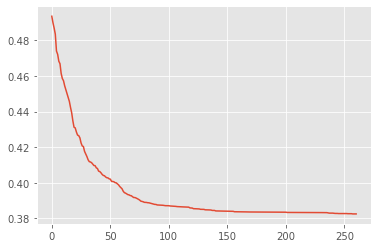

In [41]:
# Plotting the RMSE change over the training of the cross validation model above
plt.style.use('ggplot')

cv_results['test-rmse-mean'].plot()

In [42]:
# Extracting and printing the final boosting round metric.
print((cv_results["test-rmse-mean"]).tail(1))

260    0.382562
Name: test-rmse-mean, dtype: float64


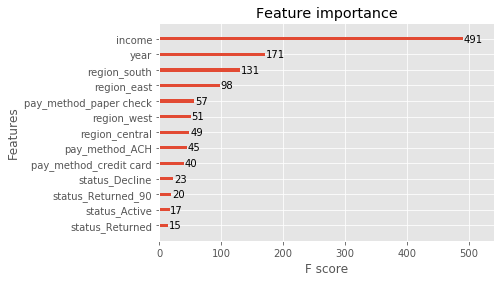

In [13]:
# Using XGBoost's feature importance to come to conclusions about the datasets
# "Building the bridge" for the company
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()